# 모델 학습 과정

### 1. 데이터 불러오기

In [31]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df

,type,code,opening_price,high_price,low_price,trade_price,trade_volume,trade_date,trade_time,trade_timestamp
0,ticker,KRW-BTC,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,2017-09-25,09:00,1506330000
1,ticker,KRW-BTC,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,2017-09-25,09:00,1506330000
2,ticker,KRW-BTC,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,2017-09-25,09:00,1506330000
3,ticker,KRW-BTC,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,2017-09-25,09:00,1506330000
4,ticker,KRW-BTC,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,2017-09-25,09:00,1506330000
...,...,...,...,...,...,...,...,...,...,...
15763,ticker,KRW-BTC,133720000.0,139920000.0,133499000.0,138760000.0,6969.870812,2024-12-04,09:00,1733302800
15764,ticker,KRW-BTC,133720000.0,139920000.0,133499000.0,138760000.0,6969.870812,2024-12-04,09:00,1733302800
15765,ticker,KRW-BTC,133720000.0,139920000.0,133499000.0,138760000.0,6969.870812,2024-12-04,09:00,1733302800
15766,ticker,KRW-BTC,133720000.0,139920000.0,133499000.0,138760000.0,6969.870812,2024-12-04,09:00,1733302800


### 2. 데이터 전처리

##### (1) 기본 입력변수 처리

In [32]:
df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)
df

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12484\22008558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])


,datetime,type,code,opening_price,closing_price,high_price,low_price,trade_volume,trade_date,year,month,day
0,2017-09-27 09:00:00,ticker,KRW-BTC,4322000.0,4657000.0,4677000.0,4318000.0,32.269662,2017-09-27,2017,9,27
1,2017-09-28 09:00:00,ticker,KRW-BTC,4657000.0,4586000.0,4772000.0,4519000.0,80.588243,2017-09-28,2017,9,28
2,2017-09-29 09:00:00,ticker,KRW-BTC,4586000.0,4657000.0,4709000.0,4476000.0,59.352373,2017-09-29,2017,9,29
3,2017-09-30 09:00:00,ticker,KRW-BTC,4657000.0,4895000.0,4896000.0,4651000.0,19.998483,2017-09-30,2017,9,30
4,2017-10-01 09:00:00,ticker,KRW-BTC,4889000.0,4962000.0,4978000.0,4682000.0,27.323332,2017-10-01,2017,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2621,2024-11-30 09:00:00,ticker,KRW-BTC,134542000.0,133701000.0,134809000.0,133600000.0,2374.866974,2024-11-30,2024,11,30
2622,2024-12-01 09:00:00,ticker,KRW-BTC,133722000.0,133802000.0,135199000.0,133297000.0,2835.146498,2024-12-01,2024,12,1
2623,2024-12-02 09:00:00,ticker,KRW-BTC,133802000.0,133535000.0,135800000.0,132260000.0,5356.774825,2024-12-02,2024,12,2
2624,2024-12-03 09:00:00,ticker,KRW-BTC,133523000.0,133700000.0,134680000.0,88266000.0,18097.084256,2024-12-03,2024,12,3


##### (2) 기술지표 변수 생성

In [33]:
# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

##### (3) 종속변수 생성 및 독립변수 선택

In [34]:
# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]

df['output'].value_counts()

output
1    1360
0    1257
Name: count, dtype: int64

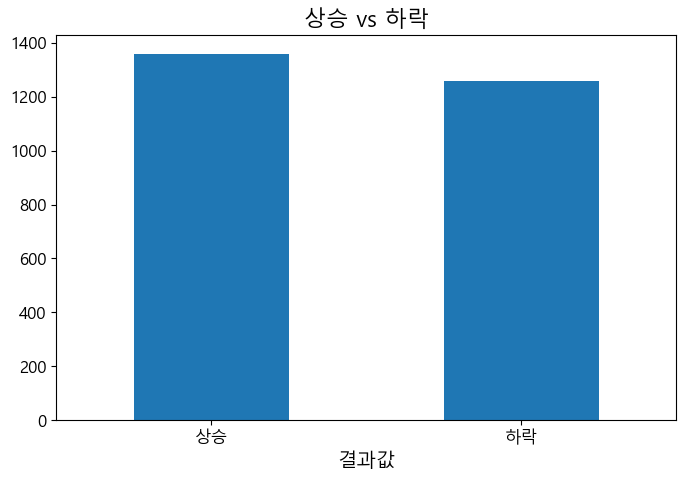

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'

# 'output' 컬럼의 값 종류와 개수 세기
value_counts = df['output'].value_counts()

# 새로운 레이블 지정
new_labels = ['상승', '하락']

# 막대그래프로 시각화
plt.figure(figsize=(8, 5))
bars = value_counts.plot(kind='bar')

# x축 레이블 변경
bars.set_xticklabels(new_labels, rotation=0)

# 글씨 크기 조정
plt.title('상승 vs 하락', fontsize=16)  # 제목 글씨 크기
plt.xlabel('결과값', fontsize=14)           # x축 레이블 글씨 크기                  # y축 레이블 글씨 크기
bars.tick_params(axis='x', labelsize=12)           # x축 tick 레이블 글씨 크기
bars.tick_params(axis='y', labelsize=12)           # y축 tick 레이블 글씨 크기

plt.show()


### 3. 데이터셋 분할

In [27]:
# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

### 4. 정규화

In [28]:
# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

### 5. 모델정의

In [29]:
# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 128
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 6. 모델학습 및 평가

In [30]:
# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")

Epoch [10/100], Loss: 0.4399
Epoch [20/100], Loss: 0.3309
Epoch [30/100], Loss: 0.5048
Epoch [40/100], Loss: 0.4175
Epoch [50/100], Loss: 0.3629
Epoch [60/100], Loss: 0.3864
Epoch [70/100], Loss: 0.4213
Epoch [80/100], Loss: 0.3399
Epoch [90/100], Loss: 0.4237
Epoch [100/100], Loss: 0.4262
Train Accuracy: 0.8286, Precision: 0.8154, Recall: 0.8736, F1: 0.8435
Test Accuracy: 0.8333, Precision: 0.7961, Recall: 0.8901, F1: 0.8405
Validation Accuracy: 0.8089, Precision: 0.8667, Recall: 0.7647, F1: 0.8125
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model.pth'


# 비트코인으로 학습

### 1. 기본 전체코드

Epoch [10/100], Loss: 0.1749
Epoch [20/100], Loss: 2.2327
Epoch [30/100], Loss: 0.1071
Epoch [40/100], Loss: 0.1203
Epoch [50/100], Loss: 0.3112
Epoch [60/100], Loss: 0.0442
Epoch [70/100], Loss: 0.0594
Epoch [80/100], Loss: 1.1952
Epoch [90/100], Loss: 0.2867
Epoch [100/100], Loss: 0.0323
Train Accuracy: 0.8495, Precision: 0.8511, Recall: 0.8670, F1: 0.8590
Test Accuracy: 0.8049, Precision: 0.7670, Recall: 0.8681, F1: 0.8144
Validation Accuracy: 0.8089, Precision: 0.8571, Recall: 0.7765, F1: 0.8148


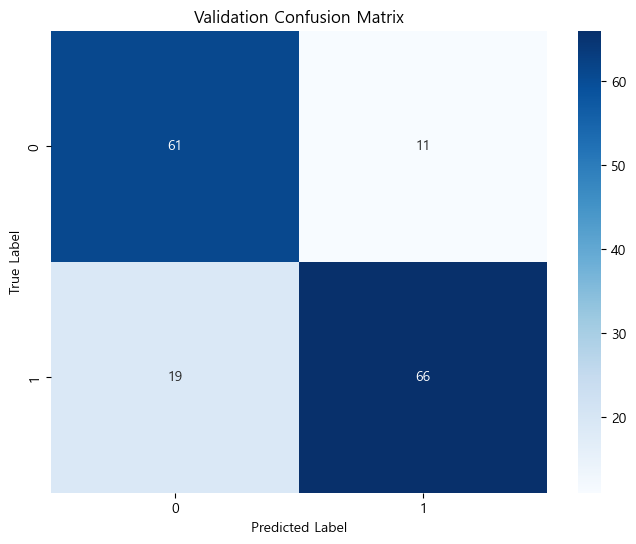

Validation results saved to 'btc_dnn_validation_predictions.csv'
Model saved to 'btc_dnn_model.pth'


In [42]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(actual, predicted, labels, title):
    cm = confusion_matrix(actual, predicted, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 혼동 행렬 시각화 (Validation 데이터)
plot_confusion_matrix(val_actual_labels, val_predictions, labels=[0, 1], title="Validation Confusion Matrix")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('btc_dnn_validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'btc_dnn_model.pth')

print(f"Validation results saved to 'btc_dnn_validation_predictions.csv'")
print(f"Model saved to 'btc_dnn_model.pth'")

### 2. 기본코드 + Glorot and Bengio (Xavier) 초기화 적용

Epoch [10/100], Loss: 0.0236
Epoch [20/100], Loss: 0.1739
Epoch [30/100], Loss: 0.8814
Epoch [40/100], Loss: 0.6624
Epoch [50/100], Loss: 0.5195
Epoch [60/100], Loss: 0.4131
Epoch [70/100], Loss: 0.3075
Epoch [80/100], Loss: 0.4740
Epoch [90/100], Loss: 0.1200
Epoch [100/100], Loss: 0.2408
Train Accuracy: 0.8489, Precision: 0.8428, Recall: 0.8780, F1: 0.8601
Test Accuracy: 0.7886, Precision: 0.7640, Recall: 0.8269, F1: 0.7942
Validation Accuracy: 0.8153, Precision: 0.9242, Recall: 0.7176, F1: 0.8079


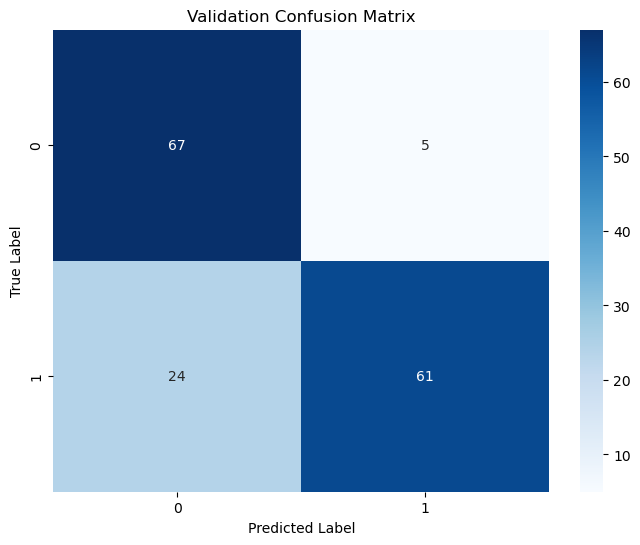

Validation results saved to 'btc_dnn_validation_predictions.csv'
Model saved to 'btc_dnn_model.pth'


In [1]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(actual, predicted, labels, title):
    cm = confusion_matrix(actual, predicted, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 혼동 행렬 시각화 (Validation 데이터)
plot_confusion_matrix(val_actual_labels, val_predictions, labels=[0, 1], title="Validation Confusion Matrix")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('btc_dnn_validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'btc_dnn_model.pth')

print(f"Validation results saved to 'btc_dnn_validation_predictions.csv'")
print(f"Model saved to 'btc_dnn_model.pth'")

Epoch [10/100], Loss: 0.5223
Epoch [20/100], Loss: 0.4453
Epoch [30/100], Loss: 0.2299
Epoch [40/100], Loss: 0.2817
Epoch [50/100], Loss: 0.2408
Epoch [60/100], Loss: 0.3296
Epoch [70/100], Loss: 0.4289
Epoch [80/100], Loss: 0.2726
Epoch [90/100], Loss: 0.4373
Epoch [100/100], Loss: 0.3461
Train Accuracy: 0.8664, Precision: 0.8795, Recall: 0.8659, F1: 0.8726
Test Accuracy: 0.7940, Precision: 0.7896, Recall: 0.7940, F1: 0.7918
Validation Accuracy: 0.7452, Precision: 0.8947, Recall: 0.6000, F1: 0.7183


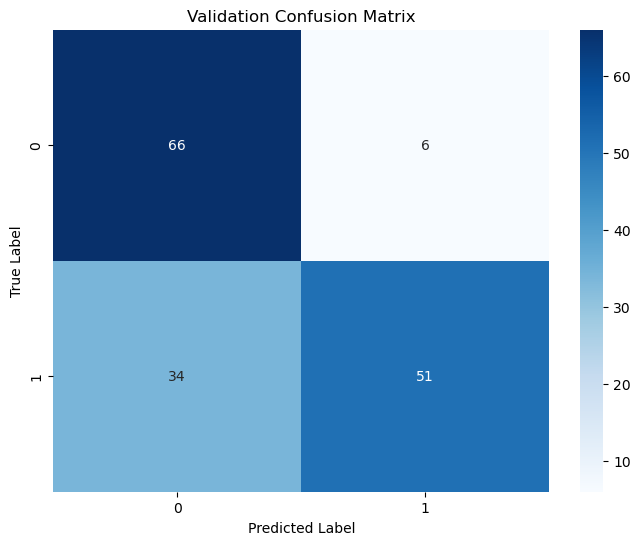

Validation results saved to 'btc_dnn_validation_predictions.csv'
Model saved to 'btc_dnn_model.pth'


In [3]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 150
batch_size = 32
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(actual, predicted, labels, title):
    cm = confusion_matrix(actual, predicted, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 혼동 행렬 시각화 (Validation 데이터)
plot_confusion_matrix(val_actual_labels, val_predictions, labels=[0, 1], title="Validation Confusion Matrix")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('btc_dnn_validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'btc_dnn_model.pth')

print(f"Validation results saved to 'btc_dnn_validation_predictions.csv'")
print(f"Model saved to 'btc_dnn_model.pth'")

Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.5056
Epoch [30/100], Loss: 0.5270
Epoch [40/100], Loss: 0.7223
Epoch [50/100], Loss: 0.5057
Epoch [60/100], Loss: 0.4087
Epoch [70/100], Loss: 0.3857
Epoch [80/100], Loss: 0.3454
Epoch [90/100], Loss: 0.3273
Epoch [100/100], Loss: 0.2478
Train Accuracy: 0.8489, Precision: 0.8571, Recall: 0.8571, F1: 0.8571
Test Accuracy: 0.7995, Precision: 0.7769, Recall: 0.8324, F1: 0.8037
Validation Accuracy: 0.8025, Precision: 0.9091, Recall: 0.7059, F1: 0.7947


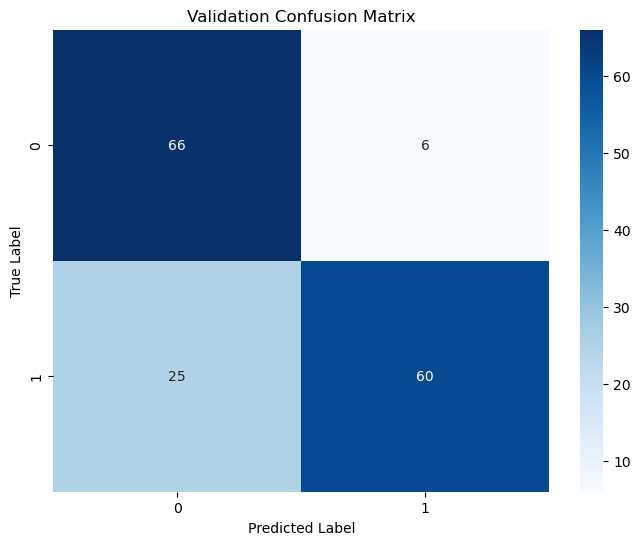

Validation results saved to 'btc_dnn_validation_predictions.csv'
Model saved to 'btc_dnn_model.pth'


In [10]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 32
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(actual, predicted, labels, title):
    cm = confusion_matrix(actual, predicted, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 혼동 행렬 시각화 (Validation 데이터)
plot_confusion_matrix(val_actual_labels, val_predictions, labels=[0, 1], title="Validation Confusion Matrix")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('btc_dnn_validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'btc_dnn_model.pth')

print(f"Validation results saved to 'btc_dnn_validation_predictions.csv'")
print(f"Model saved to 'btc_dnn_model.pth'")

### 3. 기본코드 + new 데이터로 예측

In [80]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로 (학습 데이터)
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

# 데이터베이스 파일 경로 (예측 데이터)
db_file_pred = '../btc_day_20241201_20250106.db'

# 데이터베이스 연결
con_pred = sqlite3.connect(db_file_pred)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df_pred = pd.read_sql_query(query, con_pred)

# 데이터베이스 연결 종료
con_pred.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order]
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

df_pred = df_pred.drop_duplicates(keep='first')
df_pred['datetime'] = pd.to_datetime(df_pred['trade_date'] + ' ' + df_pred['trade_time'])
df_pred = df_pred.sort_values(by='datetime')
df_pred.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df_pred = df_pred[new_column_order]
df_pred = df_pred[df_pred['trade_date']!='2017-09-26']
df_pred = df_pred[df_pred['trade_date']!='2017-09-25']
df_pred['year'] = df_pred['datetime'].dt.year
df_pred['month'] = df_pred['datetime'].dt.month
df_pred['day'] = df_pred['datetime'].dt.day
df_pred.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)
df_pred['wma_5'] = calculate_wma(df_pred)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)
df_pred = calculate_bollinger_bands(df_pred)

# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)
df_pred['rsi_9'] = calculate_rsi(df_pred)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

macd_pred, signal_pred = calculate_macd(df_pred)
df_pred['macd'] = macd_pred
df_pred['macd_signal'] = signal_pred


# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

df_pred = calculate_stochastic_oscillator(df_pred)
df_pred.dropna(inplace=True)

# 출력 변수 생성 (학습 데이터에만 적용)
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할 (학습 데이터)
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 64
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")


# 예측 데이터 로드 및 전처리 (df_pred)
predict_date = pd.to_datetime('2025-1-3 09:00:00')
predict_df = df_pred[df_pred['datetime'] == predict_date].copy()


# 입력 데이터 추출 및 정규화 (df_pred)
X_predict = predict_df[input_features].values


# 데이터 정규화 함수 (학습 데이터셋의 min, max 값 사용)
def min_max_scaling_with_params(data, min_vals, max_vals):
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data

X_predict_scaled = min_max_scaling_with_params(X_predict, min_vals_train, max_vals_train)


X_predict_scaled = torch.Tensor(X_predict_scaled).to(device)

# 모델 로드
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, x):
        return self.layers(x)


# 모델 로드 및 예측
input_size = len(input_features)
hidden_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pred = DNN(input_size,hidden_size).to(device)
model_pred.load_state_dict(torch.load('dnn_model.pth', map_location=device))
model_pred.eval()
with torch.no_grad():
    if X_predict_scaled.numel() == 0:
        print("12월 28일 데이터가 없습니다.")
    else:
      outputs = model_pred(X_predict_scaled)
      _, predicted = torch.max(outputs, 1)

      print(f"2024년 12월 12일 예측 결과 (0: 하락, 1: 상승): {predicted.item()}")

Epoch [10/100], Loss: 0.3570
Epoch [20/100], Loss: 0.3775
Epoch [30/100], Loss: 0.4127
Epoch [40/100], Loss: 0.2731
Epoch [50/100], Loss: 0.5934
Epoch [60/100], Loss: 0.4545
Epoch [70/100], Loss: 0.4947
Epoch [80/100], Loss: 0.3183
Epoch [90/100], Loss: 0.3454
Epoch [100/100], Loss: 0.3032
Train Accuracy: 0.8460, Precision: 0.8579, Recall: 0.8495, F1: 0.8537
Test Accuracy: 0.7995, Precision: 0.7983, Recall: 0.7940, F1: 0.7961
Validation Accuracy: 0.7898, Precision: 0.9194, Recall: 0.6706, F1: 0.7755
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model.pth'
2024년 12월 12일 예측 결과 (0: 하락, 1: 상승): 0


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14544\1149042224.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pred.load_state_dict(torch.load('dnn_mod

In [22]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import random
import math

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로 (학습 데이터)
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

# 데이터베이스 파일 경로 (예측 데이터)
db_file_pred = '../btc_data_day_20241206_20250101_3.db'

# 데이터베이스 연결
con_pred = sqlite3.connect(db_file_pred)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df_pred = pd.read_sql_query(query, con_pred)

# 데이터베이스 연결 종료
con_pred.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

df_pred = df_pred.drop_duplicates(keep='first')
df_pred['datetime'] = pd.to_datetime(df_pred['trade_date'] + ' ' + df_pred['trade_time'])
df_pred = df_pred.sort_values(by='datetime')
df_pred.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df_pred = df_pred[new_column_order] 
df_pred = df_pred[df_pred['trade_date']!='2017-09-26']
df_pred = df_pred[df_pred['trade_date']!='2017-09-25']
df_pred['year'] = df_pred['datetime'].dt.year
df_pred['month'] = df_pred['datetime'].dt.month
df_pred['day'] = df_pred['datetime'].dt.day
df_pred.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)
df_pred['wma_5'] = calculate_wma(df_pred)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)
df_pred = calculate_bollinger_bands(df_pred)

# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)
df_pred['rsi_9'] = calculate_rsi(df_pred)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

macd_pred, signal_pred = calculate_macd(df_pred)
df_pred['macd'] = macd_pred
df_pred['macd_signal'] = signal_pred


# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

df_pred = calculate_stochastic_oscillator(df_pred)
df_pred.dropna(inplace=True)

# 출력 변수 생성 (학습 데이터에만 적용)
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할 (학습 데이터)
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 64
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")



# 예측 데이터 로드 및 전처리 (df_pred)
predict_date = pd.to_datetime('2024-12-17 09:00:00')
predict_df = df_pred[df_pred['datetime'] == predict_date].copy()

# 입력 데이터 추출 및 정규화 (df_pred)
X_predict = predict_df[input_features].values


# 데이터 정규화 함수 (학습 데이터셋의 min, max 값 사용)
def min_max_scaling_with_params(data, min_vals, max_vals):
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data

X_predict_scaled = min_max_scaling_with_params(X_predict, min_vals_train, max_vals_train)


X_predict_scaled = torch.Tensor(X_predict_scaled).to(device)

# 모델 로드
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )
        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)


# 모델 로드 및 예측
input_size = len(input_features)
hidden_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pred = DNN(input_size,hidden_size).to(device)
model_pred.load_state_dict(torch.load('dnn_model.pth', map_location=device))
model_pred.eval()
with torch.no_grad():
  if X_predict_scaled.numel() == 0:
        print("12월 28일 데이터가 없습니다.")
  else:
        outputs = model_pred(X_predict_scaled)
        _, predicted = torch.max(outputs, 1)

        print(f"12월 28일 예측 결과 (0: 하락, 1: 상승): {predicted.item()}")

Epoch [10/100], Loss: 0.3570
Epoch [20/100], Loss: 0.3775
Epoch [30/100], Loss: 0.4127
Epoch [40/100], Loss: 0.2731
Epoch [50/100], Loss: 0.5934
Epoch [60/100], Loss: 0.4545
Epoch [70/100], Loss: 0.4947
Epoch [80/100], Loss: 0.3183
Epoch [90/100], Loss: 0.3454
Epoch [100/100], Loss: 0.3032
Train Accuracy: 0.8460, Precision: 0.8579, Recall: 0.8495, F1: 0.8537
Test Accuracy: 0.7995, Precision: 0.7983, Recall: 0.7940, F1: 0.7961
Validation Accuracy: 0.7898, Precision: 0.9194, Recall: 0.6706, F1: 0.7755
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model.pth'
12월 28일 예측 결과 (0: 하락, 1: 상승): 0


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12484\443974524.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pred.load_state_dict(torch.load('dnn_mode

# 솔라나

In [56]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터베이스 파일 경로 (학습 데이터)
db_file = '../solana_data_day_20211001_20250102.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)


# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)


# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)


# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal




# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)


# 출력 변수 생성 (학습 데이터에만 적용)
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할 (학습 데이터)
train_end_date = pd.to_datetime('2024-11-30')
validation_start_date = pd.to_datetime('2024-12-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")


Epoch [10/100], Loss: 0.0455
Epoch [20/100], Loss: 0.2372
Epoch [30/100], Loss: 1.0142
Epoch [40/100], Loss: 0.1072
Epoch [50/100], Loss: 0.0202
Epoch [60/100], Loss: 0.1517
Epoch [70/100], Loss: 0.4010
Epoch [80/100], Loss: 1.5461
Epoch [90/100], Loss: 0.0425
Epoch [100/100], Loss: 0.2120
Train Accuracy: 0.8625, Precision: 0.7910, Recall: 0.9712, F1: 0.8719
Test Accuracy: 0.8029, Precision: 0.7265, Recall: 0.9827, F1: 0.8354
Validation Accuracy: 0.8438, Precision: 0.7647, Recall: 0.9286, F1: 0.8387
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model.pth'


In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import random
import math

# 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터베이스 파일 경로 (학습 데이터)
db_file = '../solana_data_day_20211001_20250102.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)


# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)


# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)


# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal




# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)


# 출력 변수 생성 (학습 데이터에만 적용)
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할 (학습 데이터)
train_end_date = pd.to_datetime('2024-11-30')
validation_start_date = pd.to_datetime('2024-12-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")

# 도지코인

In [50]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터베이스 파일 경로 (학습 데이터)
db_file = '../doge_data_daily_20210201_current.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)


# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)


# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)


# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal




# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)


# 출력 변수 생성 (학습 데이터에만 적용)
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할 (학습 데이터)
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model.pth'")





Epoch [10/100], Loss: 0.4109
Epoch [20/100], Loss: 0.5753
Epoch [30/100], Loss: 0.5551
Epoch [40/100], Loss: 0.6727
Epoch [50/100], Loss: 0.1644
Epoch [60/100], Loss: 0.1078
Epoch [70/100], Loss: 0.3004
Epoch [80/100], Loss: 0.4353
Epoch [90/100], Loss: 0.1188
Epoch [100/100], Loss: 0.1866
Train Accuracy: 0.8751, Precision: 0.8597, Recall: 0.8686, F1: 0.8641
Test Accuracy: 0.8274, Precision: 0.8609, Recall: 0.7558, F1: 0.8050
Validation Accuracy: 0.8011, Precision: 0.7944, Recall: 0.8500, F1: 0.8213
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model.pth'


15분봉

In [33]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터베이스 파일 경로
db_file = '../btc_data_m15_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)
# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]


# 데이터셋 분할
train_end_date = pd.to_datetime('2023-12-31')
validation_start_date = pd.to_datetime('2024-01-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# DNN 모델 정의
# ----------------------------
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2) # 이진 분류를 위한 출력 크기 2
        )

    def forward(self, x):
        return self.layers(x)

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 100
batch_size = 10
epochs = 100
learning_rate = 0.001

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_dataset = TensorDataset(torch.Tensor(X_train_scaled).to(device), torch.LongTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_scaled).to(device), torch.LongTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_validation_scaled).to(device), torch.LongTensor(y_validation).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size,hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 :
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates, 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
val_results.to_csv('btc_m15_validation_predictions.csv', index=False)

# 모델 저장
torch.save(model.state_dict(), 'dnn_model.pth')

print(f"Validation results saved to 'validation_predictions.csv'")
print(f"Model saved to 'dnn_model_btc_m15.pth'")

Epoch [10/100], Loss: 0.0335
Epoch [20/100], Loss: 0.0250
Epoch [30/100], Loss: 0.4144
Epoch [40/100], Loss: 0.3010
Epoch [50/100], Loss: 0.5074
Epoch [60/100], Loss: 0.0116
Epoch [70/100], Loss: 0.1924
Epoch [80/100], Loss: 0.9299
Epoch [90/100], Loss: 0.2606
Epoch [100/100], Loss: 0.4374
Train Accuracy: 0.8442, Precision: 0.8535, Recall: 0.8241, F1: 0.8385
Test Accuracy: 0.8470, Precision: 0.8434, Recall: 0.8488, F1: 0.8461
Validation Accuracy: 0.8544, Precision: 0.8642, Recall: 0.8421, F1: 0.8530
Validation results saved to 'validation_predictions.csv'
Model saved to 'dnn_model_btc_m15.pth'
